In [2]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(.76,.76,.76),use_voxels=False)
    return FDA, FDA_lowres

FDA, FDA_lowres = load_FDA()

In [4]:
dir_ = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/func/average_green_LC11_clab_fda.nii"
LC11_alex_FDA = ants.image_read(dir_)

In [5]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220704_LC11/andrew_pipeline4/templates/syn_1.nii"
meansub_vol = ants.image_read(file)
meansub_vol = meansub_vol[:,:,::-1]
### TRIM
t = 20
meansub_vol = ants.from_numpy(meansub_vol[t:-t,t:-t,t:-t])
meansub_vol.set_spacing((0.65,0.65,1))

# Align subvol to FDA

In [6]:
### width of subvol comes directly from subvol
xr = int(meansub_vol.shape[0]/2)
yr = int(meansub_vol.shape[1]/2)
zr = int(meansub_vol.shape[2]/2)
print(xr,yr,zr)

105 105 30


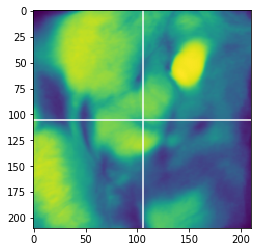

In [70]:
plt.imshow(meansub_vol[:,:,zr].T)
plt.axhline(xr,color='w')
plt.axvline(yr,color='w')

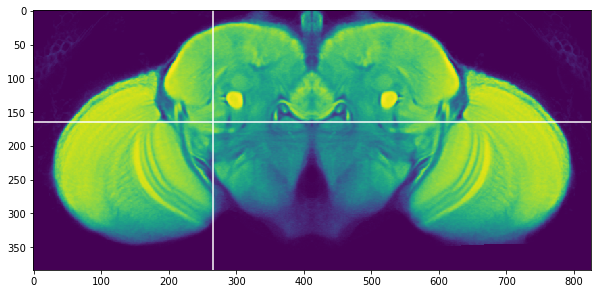

In [71]:
############################################################
### user must estimate the center of their subvol on FDA ###
############################################################

xc = 265
yc = 165
zc = 155

plt.figure(figsize=(10,10))
plt.imshow(FDA_lowres[:,:,zc].T)
plt.axvline(xc,color='w')
plt.axhline(yc,color='w')

In [72]:
new_box = []
for i,r in enumerate([xr,yr,zr]):
    new_box.append(int(r*meansub_vol.spacing[i]/FDA_lowres.spacing[i]))
xr = new_box[0]
yr = new_box[1]
zr = new_box[2]

In [145]:
### need to crop FDA down to the approximate subvol region
FDA_lowres_cropped = FDA_lowres[xc-xr:xc+xr,yc-yr:yc+yr,zc-zr:zc+zr]
FDA_lowres_cropped = ants.from_numpy(FDA_lowres_cropped)
FDA_lowres_cropped.set_spacing((.76,.76,.76))

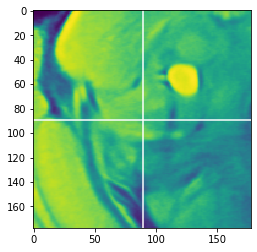

In [146]:
plt.imshow(FDA_lowres_cropped[:,:,zr].T)
plt.axhline(xr,color='w')
plt.axvline(yr,color='w')

In [75]:
fixed = FDA_lowres_cropped
moving = meansub_vol
subvol_to_FDA = ants.registration(fixed=fixed, moving=moving, type_of_transform='SyN')

In [98]:
def draw_grid():
    for i in np.arange(0,180,30):
        plt.axvline(i,color='w')
    for i in np.arange(0,180,30):
        plt.axhline(i,color='w')

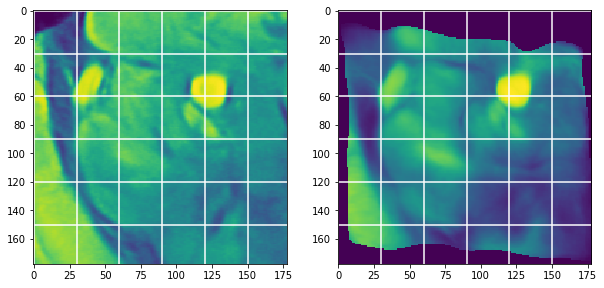

In [99]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(fixed[:,:,20].T)
draw_grid()

plt.subplot(1,2,2)
plt.imshow(subvol_to_FDA['warpedmovout'][:,:,20].T)
draw_grid()

# Align individual flies to FDA through subvol

In [169]:
############################################
### LOAD ALEX LC11 IN FDA FOR COMPARISON ###
############################################

dir_ = "/oak/stanford/groups/trc/data/Alex/clab_data/LC11/func/average_green_LC11_clab_fda.nii"
alex_mean_LC11_in_FDA = ants.image_read(dir_)
alex_mean_LC11_in_FDA.shape

(826, 384, 240)

In [100]:
### THESE ARE LC11 BRAINS I'VE ALREADY CROPPED DOWN TO CRUDE PVLP REGION
red_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220627_LC11/raw_red'
green_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220627_LC11/raw_green'

In [196]:
green_in_FDA = []

for file in os.listdir(red_directory):
    print(file)
    
    ###################
    ### LOAD BRAINS ###
    ###################
    
    red_file = os.path.join(red_directory,file)
    brain_red = ants.from_numpy(np.load(red_file)[:,:,::-1])
    brain_red.set_spacing((.65,.65,1))
    green_file = os.path.join(green_directory, file.replace('red', 'green'))
    brain_green = ants.from_numpy(np.load(green_file)[:,:,::-1])
    brain_green.set_spacing((.65,.65,1))
    
    #######################################
    ### ALIGN RED SUBVOL TO MEAN-SUBVOL ###
    #######################################
    
    fixed = meansub_vol
    moving = brain_red
    red_to_mean = ants.registration(fixed=fixed, moving=moving, type_of_transform='SyN')
    
    ########################################
    ### APPLY TRANFORMS TO GREEN CHANNEL ###
    ########################################
    
    fixed = meansub_vol
    moving = brain_green
    green_to_mean = ants.apply_transforms(fixed, moving, transformlist=red_to_mean["fwdtransforms"])
    
    ##############################
    ### APPLY TRANSFORM TO FDA ###
    ##############################
    
    fixed = FDA_lowres_cropped
    moving = green_to_mean
    green_to_FDA = ants.apply_transforms(fixed, moving, transformlist=subvol_to_FDA["fwdtransforms"])
    
    ###################
    ### UN-CROP FDA ###
    ###################

    full_vol = np.zeros(FDA_lowres.shape)
    full_vol[xc-xr:xc+xr,yc-yr:yc+yr,zc-zr:zc+zr] = green_to_FDA.numpy()
    full_vol = full_vol[:,:,::-1]
    green_in_FDA.append(full_vol)

210218_02_red_o.npy
210218_02_red_m.npy
210223_01_red_o.npy
210223_02_red_o.npy
210216_02_red_m.npy
210208_03_red_m.npy
210223_04_red_m.npy
210223_01_red_m.npy
210208_02_red_m.npy
210216_02_red_o.npy
210223_03_red_o.npy
210216_04_red_o.npy
210208_03_red_o.npy
210223_04_red_o.npy
210223_03_red_m.npy
210216_04_red_m.npy
210208_02_red_o.npy
210223_02_red_m.npy


In [202]:
mean_LC11_subvol_in_FDA = np.mean(np.asarray(green_in_FDA),axis=0)

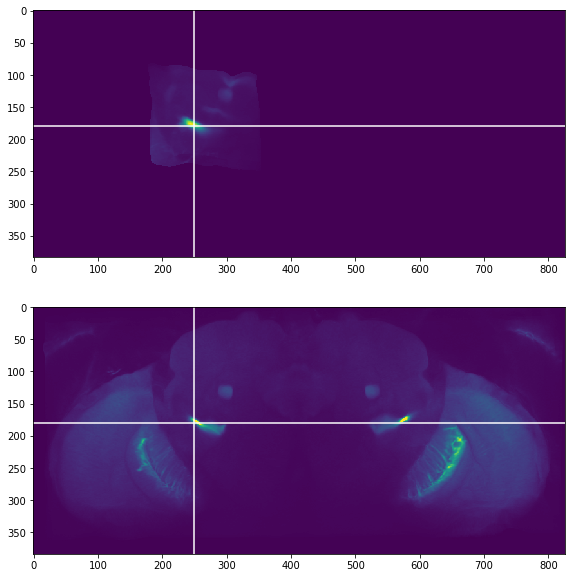

In [208]:
plt.figure(figsize=(10,10))
z=100

plt.subplot(2,1,1)
plt.imshow(mean_LC11_subvol_in_FDA[:,:,z].T)
plt.axvline(250,color='w')
plt.axhline(180,color='w')

plt.subplot(2,1,2)
plt.imshow(alex_mean_LC11_in_FDA[:,:,z].T,vmax=2000)
plt.axvline(250,color='w')
plt.axhline(180,color='w')

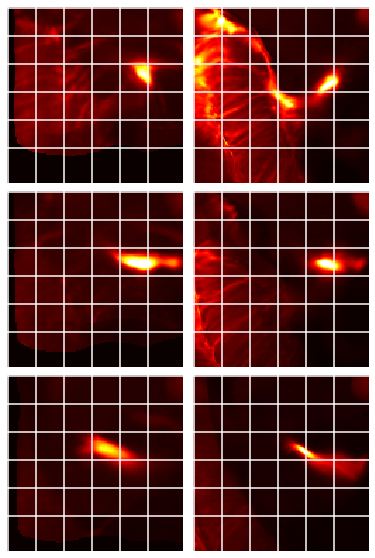

In [244]:
### VISUALIZE SLICES ###
#lines are ~15um apart
def draw_grid():
    for i in np.arange(0,120,20):
        plt.axvline(i,color='w')
    for i in np.arange(0,120,20):
        plt.axhline(i,color='w')

plt.figure(figsize=(10,10))
z=100

for i,z in enumerate([60,80,100]):
    plt.subplot(3,2,((i+1)*2)-1)
    plt.imshow(mean_LC11_subvol_in_FDA[175:300,125:250,z].T,vmax=3000,cmap='hot')
    draw_grid()
    plt.axis('off')

    plt.subplot(3,2,((i+1)*2))
    plt.imshow(alex_mean_LC11_in_FDA[175:300,125:250,z].T,vmax=3000,cmap='hot')
    draw_grid()
    plt.axis('off')
    
plt.subplots_adjust(wspace=-.5,hspace=.05)

In [269]:
file = "/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/sama_local_meanbrain/templates/syn_1.nii"
brain = ants.image_read(file)

In [270]:
brain.shape

(1024, 700, 249)

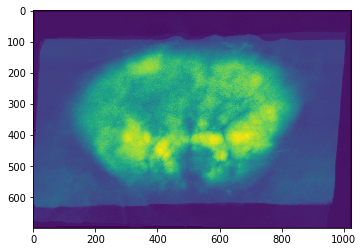

In [271]:
plt.imshow(brain[:,:,60].T)

In [278]:
dir_="/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/sama_local_meanbrain/preprocessed"

for file in os.listdir(dir_)[0:2]:
    print(file)
    
    ###################
    ### LOAD BRAINS ###
    ###################
    
    red_file = os.path.join(dir_,file)
    brain_red = ants.image_read(red_file)
    
    #######################################
    ### ALIGN RED SUBVOL TO MEAN-SUBVOL ###
    #######################################
    
    fixed = brain
    moving = brain_red
    red_to_mean = ants.registration(fixed=fixed, moving=moving, type_of_transform='SyN')



220127_local_atlas.nii
220125_local_atlas.nii


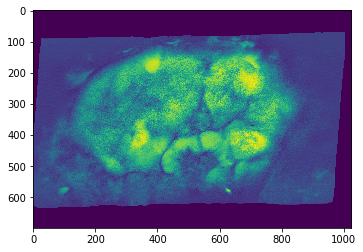

In [279]:
plt.imshow(red_to_mean['warpedmovout'][:,:,60].T)